In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error, root_mean_squared_error
import matplotlib.pylab as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

import tensorflow as tf
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Dense, Input, Dropout, LSTM
from keras._tf_keras.keras.regularizers import l2

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
df0 = pd.read_csv('ETH-USD.csv', index_col=0, parse_dates=True)
df = df0[['Close']].copy()
df['LogClose'] = np.log(df['Close'])
df['DiffLogClose'] = df['LogClose'].diff()

In [3]:
def build_lstm_model(activation = 'relu', units=50, dropout_rate=0.2, regularization_rate=0.01, optimizer='adam'):
    i = Input(shape=(Tx,1)) 
    x = LSTM(units, activation=activation, kernel_regularizer=l2(regularization_rate), 
    return_sequences=True)(i) 
    x = Dropout(dropout_rate)(x)  
    x = LSTM(units, activation=activation, kernel_regularizer=l2(regularization_rate), return_sequences=False)(x) 
    x = Dropout(dropout_rate)(x) 
    x = Dense(Ty)(x)  
    model = Model(inputs=i, outputs=x)
    model.compile(loss='mape', optimizer=optimizer) 
    return model

In [4]:
param_grid = {
    'model__units': [32, 64],  
    'model__activation': ['relu', 'sigmoid'],  
    'model__optimizer': ['adam', 'rmsprop'],  
    'model__dropout_rate': [0.1, 0.2], 
    'model__regularization_rate': [0.01, 0.001], 
    'epochs': [50, 100],
}

Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/100
9/9 - 11s - 1s/step - loss: 117.2818 - val_loss: 100.6500
Epoch 2/100
9/9 - 0s - 23ms/step - loss: 114.0532 - val_loss: 100.6370
Epoch 3/100
9/9 - 0s - 24ms/step - loss: 107.2601 - val_loss: 100.1086
Epoch 4/100
9/9 - 0s - 24ms/step - loss: 105.8984 - val_loss: 100.1903
Epoch 5/100
9/9 - 0s - 24ms/step - loss: 105.7191 - val_loss: 100.3072
Epoch 6/100
9/9 - 0s - 24ms/step - loss: 104.8737 - val_loss: 100.4167
Epoch 7/100
9/9 - 0s - 24ms/step - loss: 104.6043 - val_loss: 100.2237
Epoch 8/100
9/9 - 0s - 24ms/step - loss: 105.5318 - val_loss: 100.1431
Epoch 9/100
9/9 - 0s - 24ms/step - loss: 104.2637 - val_loss: 100.3051
Epoch 10/100
9/9 - 0s - 24ms/step - loss: 105.2350 - val_loss: 100.3458
Epoch 11/100
9/9 - 0s - 26ms/step - loss: 103.2772 - val_loss: 100.2960
Epoch 12/100
9/9 - 0s - 23ms/step - loss: 102.4446 - val_loss: 100.1510
Epoch 13/100
9/9 - 0s - 24ms/step - loss: 103.2801 - val_loss: 100.0506
Epoch 14/100

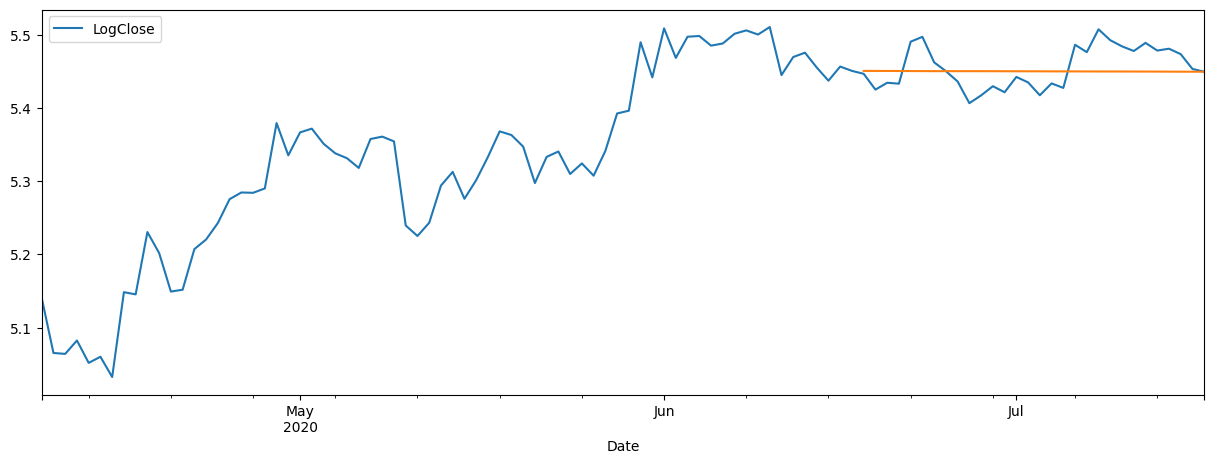

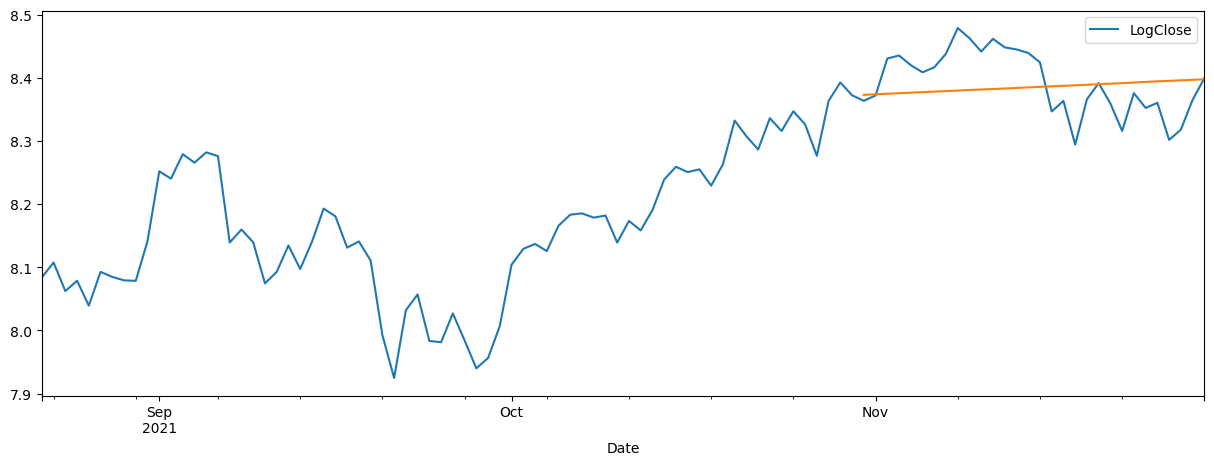

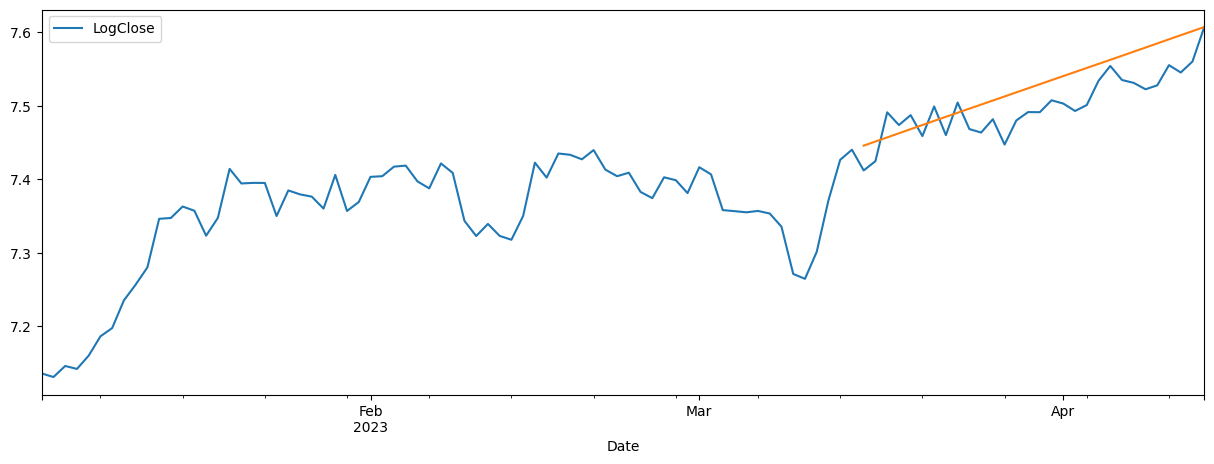

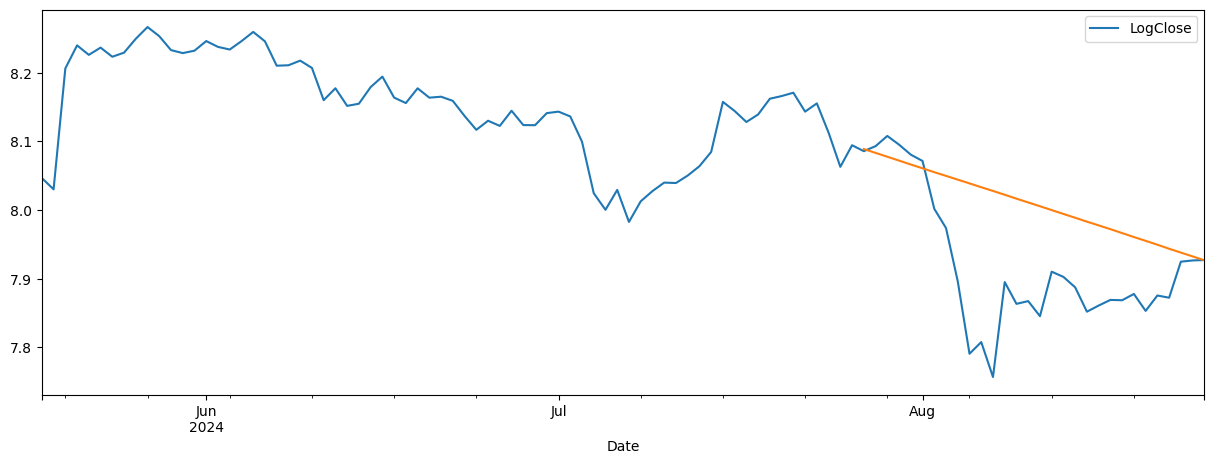

In [6]:
i = 328
real_10d = []
pred_10d = []
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 30
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    Tx = 10
    Ty = Ntest
    X = []
    Y = []
    for t in range(len(series) - Tx - Ty + 1):
      x = series[t:t+Tx]
      X.append(x)
      y = series[t+Tx:t+Tx+Ty]
      Y.append(y)
    
    X = np.array(X).reshape(-1, Tx,1)
    Y = np.array(Y).reshape(-1, Ty)
    
    Xtrain_m, Ytrain_m = X[:-Ntest], Y[:-Ntest]
    Xtest_m, Ytest_m = X[-Ntest:], Y[-Ntest:]
    
    model = KerasRegressor(model=build_lstm_model, verbose=2)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain_m, Ytrain_m,validation_data=(Xtest_m, Ytest_m))
    best_model = grid_result.best_estimator_
    
    Ptest = best_model.predict(Xtest_m)
    
    Ptest = Ptest[0]
    
    Ptest = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()
    
    last_train = train.iloc[-1]['LogClose']
    
    temp.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'multioutput']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.iloc[-100:][['LogClose']].plot(figsize=(15, 5));
    plt.plot(temp.loc[test_idx, 'multioutput'])
    
    pred_10d.append(predicted_temp)
    real_10d.append(real_temp)
    print(pred_10d)
    print('############')
    print(real_10d)

Fitting 2 folds for each of 64 candidates, totalling 128 fits


C:\Users\Korisnik\Desktop\Diplomski\Eth_price_prediciton\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/50
7/7 - 9s - 1s/step - loss: 1406.8134 - val_loss: 250.3893
Epoch 2/50
7/7 - 0s - 51ms/step - loss: 1226.1638 - val_loss: 222.7373
Epoch 3/50
7/7 - 0s - 51ms/step - loss: 1132.3835 - val_loss: 202.7680
Epoch 4/50
7/7 - 0s - 51ms/step - loss: 1004.1438 - val_loss: 185.1478
Epoch 5/50
7/7 - 0s - 49ms/step - loss: 846.4662 - val_loss: 169.4889
Epoch 6/50
7/7 - 0s - 49ms/step - loss: 664.3755 - val_loss: 157.6974
Epoch 7/50
7/7 - 0s - 51ms/step - loss: 728.4153 - val_loss: 148.8030
Epoch 8/50
7/7 - 0s - 49ms/step - loss: 630.0200 - val_loss: 139.8426
Epoch 9/50
7/7 - 0s - 51ms/step - loss: 580.1434 - val_loss: 132.5470
Epoch 10/50
7/7 - 0s - 65ms/step - loss: 568.1428 - val_loss: 128.5019
Epoch 11/50
7/7 - 0s - 49ms/step - loss: 515.9138 - val_loss: 125.7931
Epoch 12/50
7/7 - 0s - 51ms/step - loss: 548.8692 - val_loss: 122.9880
Epoch 13/50
7/7 - 0s - 58ms/step - loss: 497.5721 - val_loss: 119.6028
Epoch 14/50
7/7 - 0s - 54ms/step - loss: 582.1214 - val_loss: 116.5803
Epoch 15/50
7

C:\Users\Korisnik\Desktop\Diplomski\Eth_price_prediciton\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/100
23/23 - 7s - 317ms/step - loss: 103.0577 - val_loss: 100.3777
Epoch 2/100
23/23 - 1s - 26ms/step - loss: 101.5922 - val_loss: 100.2627
Epoch 3/100
23/23 - 1s - 26ms/step - loss: 101.0144 - val_loss: 99.9934
Epoch 4/100
23/23 - 1s - 25ms/step - loss: 100.6337 - val_loss: 100.2031
Epoch 5/100
23/23 - 1s - 26ms/step - loss: 100.3520 - val_loss: 100.2706
Epoch 6/100
23/23 - 1s - 25ms/step - loss: 100.3831 - val_loss: 100.1921
Epoch 7/100
23/23 - 1s - 26ms/step - loss: 100.4077 - val_loss: 100.2421
Epoch 8/100
23/23 - 1s - 26ms/step - loss: 100.2079 - val_loss: 100.2164
Epoch 9/100
23/23 - 1s - 25ms/step - loss: 100.2076 - val_loss: 100.1027
Epoch 10/100
23/23 - 1s - 26ms/step - loss: 100.2721 - val_loss: 100.2901
Epoch 11/100
23/23 - 1s - 25ms/step - loss: 100.2131 - val_loss: 100.2177
Epoch 12/100
23/23 - 1s - 25ms/step - loss: 100.2299 - val_loss: 100.3053
Epoch 13/100
23/23 - 1s - 26ms/step - loss: 100.1445 - val_loss: 100.2448
Epoch 14/100
23/23 - 1s - 26ms/step - loss: 100

C:\Users\Korisnik\Desktop\Diplomski\Eth_price_prediciton\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/50
39/39 - 5s - 140ms/step - loss: 254.5312 - val_loss: 134.4156
Epoch 2/50
39/39 - 1s - 21ms/step - loss: 184.0723 - val_loss: 118.0847
Epoch 3/50
39/39 - 1s - 21ms/step - loss: 172.1208 - val_loss: 110.6537
Epoch 4/50
39/39 - 1s - 21ms/step - loss: 156.2455 - val_loss: 118.1286
Epoch 5/50
39/39 - 1s - 21ms/step - loss: 156.5293 - val_loss: 117.9477
Epoch 6/50
39/39 - 1s - 20ms/step - loss: 150.3873 - val_loss: 113.4469
Epoch 7/50
39/39 - 1s - 20ms/step - loss: 145.1866 - val_loss: 109.2628
Epoch 8/50
39/39 - 1s - 21ms/step - loss: 140.1365 - val_loss: 111.9726
Epoch 9/50
39/39 - 1s - 21ms/step - loss: 138.5325 - val_loss: 111.4237
Epoch 10/50
39/39 - 1s - 20ms/step - loss: 134.3644 - val_loss: 110.2322
Epoch 11/50
39/39 - 1s - 21ms/step - loss: 131.8520 - val_loss: 109.3763
Epoch 12/50
39/39 - 1s - 20ms/step - loss: 128.8561 - val_loss: 107.0323
Epoch 13/50
39/39 - 1s - 21ms/step - loss: 126.4147 - val_loss: 108.2529
Epoch 14/50
39/39 - 1s - 21ms/step - loss: 122.8204 - val_l

C:\Users\Korisnik\Desktop\Diplomski\Eth_price_prediciton\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/100
54/54 - 5s - 95ms/step - loss: 249.6220 - val_loss: 103.5727
Epoch 2/100
54/54 - 1s - 27ms/step - loss: 179.0467 - val_loss: 100.8267
Epoch 3/100
54/54 - 1s - 26ms/step - loss: 152.3884 - val_loss: 100.8532
Epoch 4/100
54/54 - 1s - 26ms/step - loss: 132.7529 - val_loss: 100.0816
Epoch 5/100
54/54 - 1s - 26ms/step - loss: 120.6318 - val_loss: 100.5714
Epoch 6/100
54/54 - 1s - 27ms/step - loss: 114.0436 - val_loss: 100.1045
Epoch 7/100
54/54 - 1s - 27ms/step - loss: 111.4256 - val_loss: 100.2298
Epoch 8/100
54/54 - 1s - 27ms/step - loss: 107.5434 - val_loss: 100.2747
Epoch 9/100
54/54 - 1s - 26ms/step - loss: 106.4323 - val_loss: 100.0095
Epoch 10/100
54/54 - 1s - 27ms/step - loss: 105.5480 - val_loss: 100.1595
Epoch 11/100
54/54 - 1s - 26ms/step - loss: 104.3261 - val_loss: 100.2130
Epoch 12/100
54/54 - 1s - 26ms/step - loss: 103.8453 - val_loss: 100.0998
Epoch 13/100
54/54 - 1s - 26ms/step - loss: 103.1165 - val_loss: 100.1426
Epoch 14/100
54/54 - 1s - 27ms/step - loss: 103

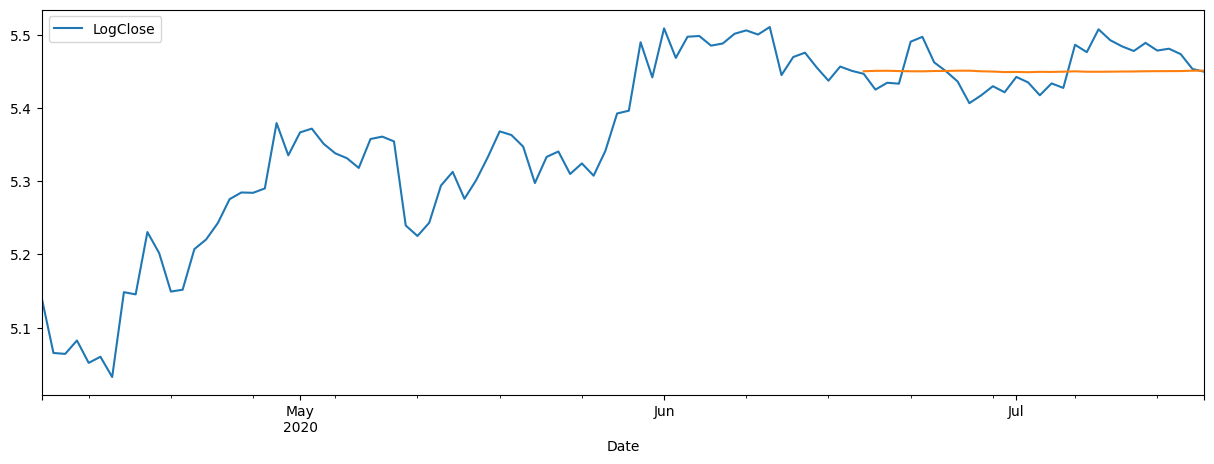

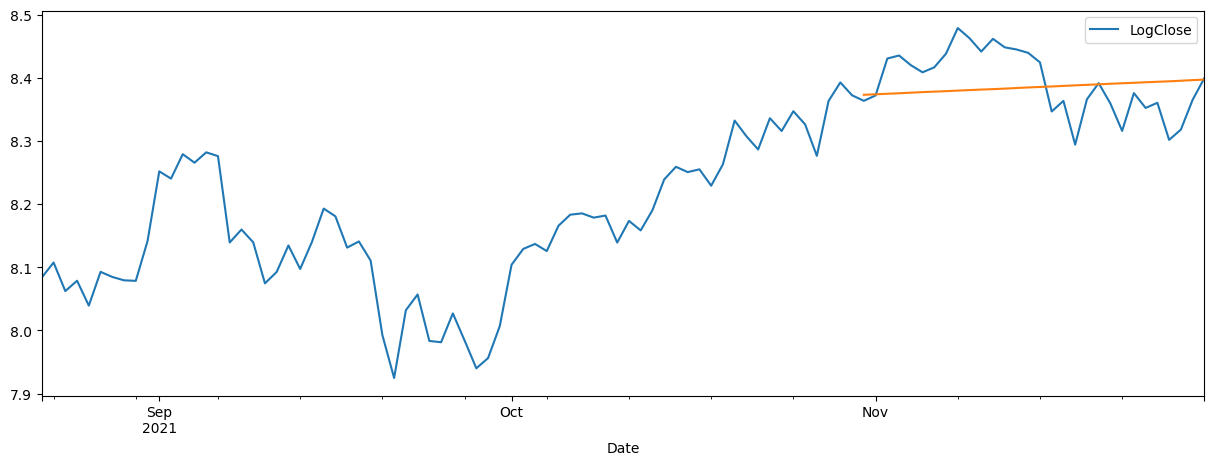

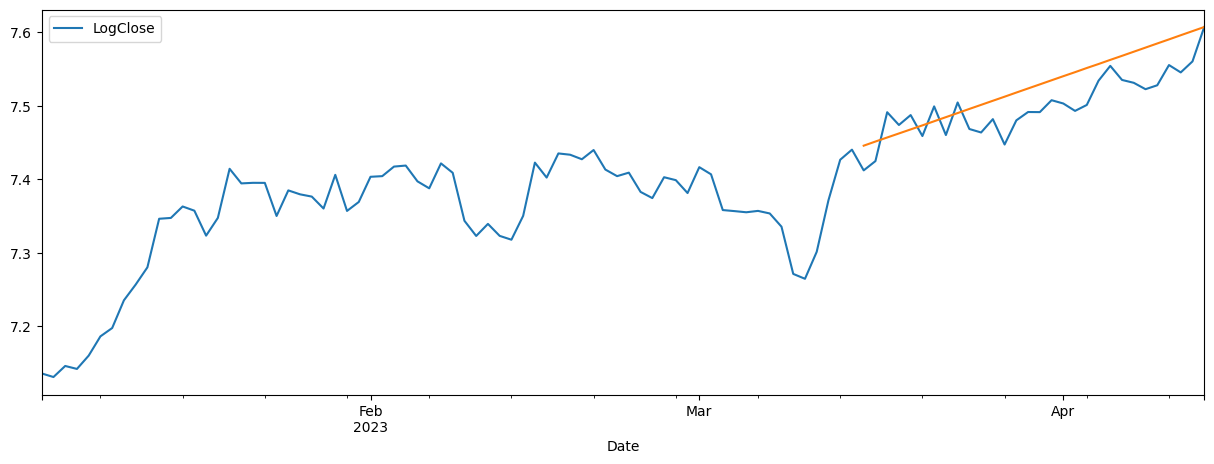

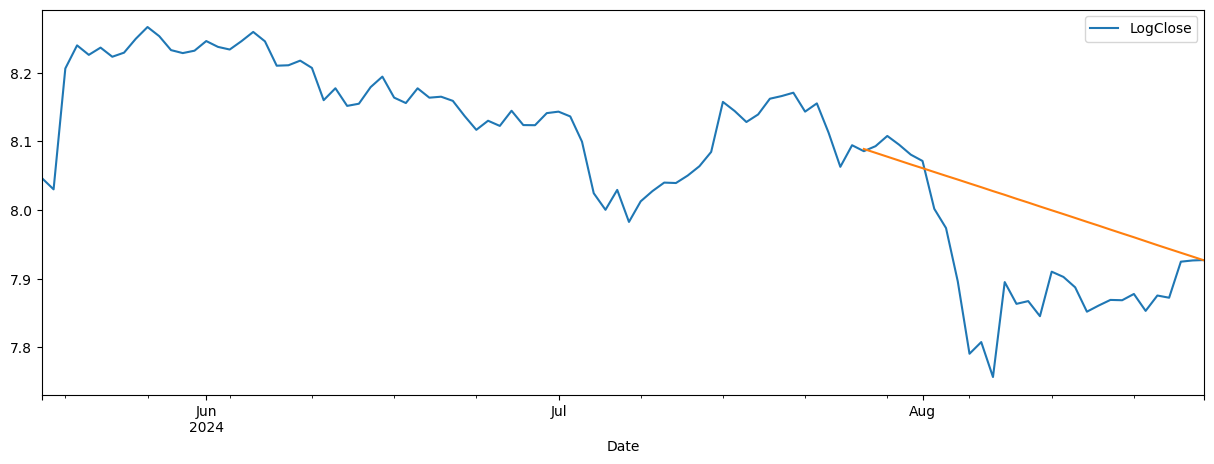

In [16]:
i = 328
real_50d = []
pred_50d = []
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 30
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    Tx = 50
    Ty = Ntest
    X = []
    Y = []
    for t in range(len(series) - Tx - Ty + 1):
      x = series[t:t+Tx]
      X.append(x)
      y = series[t+Tx:t+Tx+Ty]
      Y.append(y)
    
    X = np.array(X).reshape(-1, Tx,1)
    Y = np.array(Y).reshape(-1, Ty)
    
    Xtrain_m, Ytrain_m = X[:-Ntest], Y[:-Ntest]
    Xtest_m, Ytest_m = X[-Ntest:], Y[-Ntest:]
    
    model = KerasRegressor(model=build_lstm_model, verbose=2)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain_m, Ytrain_m,validation_data=(Xtest_m, Ytest_m))
    best_model = grid_result.best_estimator_
    
    Ptest = best_model.predict(Xtest_m)
    
    Ptest = Ptest[0]
    
    Ptest = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()
    
    last_train = train.iloc[-1]['LogClose']
    
    temp.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'multioutput']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.iloc[-100:][['LogClose']].plot(figsize=(15, 5));
    plt.plot(temp.loc[test_idx, 'multioutput'])
    
    pred_50d.append(predicted_temp)
    real_50d.append(real_temp)
    print(pred_50d)
    print('############')
    print(real_50d)

Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/50
7/7 - 4s - 575ms/step - loss: 585.3500 - val_loss: 143.3189
Epoch 2/50
7/7 - 0s - 29ms/step - loss: 501.7581 - val_loss: 136.6726
Epoch 3/50
7/7 - 0s - 28ms/step - loss: 465.4389 - val_loss: 125.0514
Epoch 4/50
7/7 - 0s - 29ms/step - loss: 410.6650 - val_loss: 120.5077
Epoch 5/50
7/7 - 0s - 27ms/step - loss: 397.6081 - val_loss: 121.1847
Epoch 6/50
7/7 - 0s - 27ms/step - loss: 447.0472 - val_loss: 120.3154
Epoch 7/50
7/7 - 0s - 28ms/step - loss: 463.3814 - val_loss: 123.5408
Epoch 8/50
7/7 - 0s - 28ms/step - loss: 413.6723 - val_loss: 113.3012
Epoch 9/50
7/7 - 0s - 28ms/step - loss: 372.4832 - val_loss: 115.0408
Epoch 10/50
7/7 - 0s - 29ms/step - loss: 335.9835 - val_loss: 114.9588
Epoch 11/50
7/7 - 0s - 29ms/step - loss: 431.5786 - val_loss: 114.0884
Epoch 12/50
7/7 - 0s - 29ms/step - loss: 374.0438 - val_loss: 109.1849
Epoch 13/50
7/7 - 0s - 28ms/step - loss: 365.8641 - val_loss: 112.3315
Epoch 14/50
7/7 - 0s - 

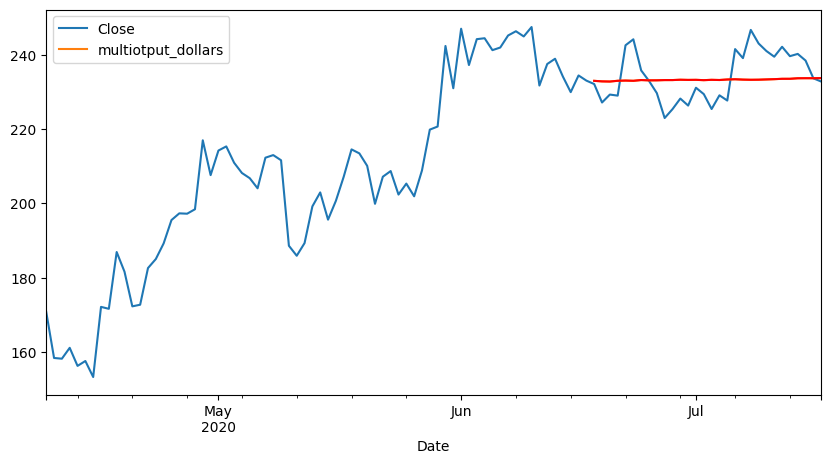

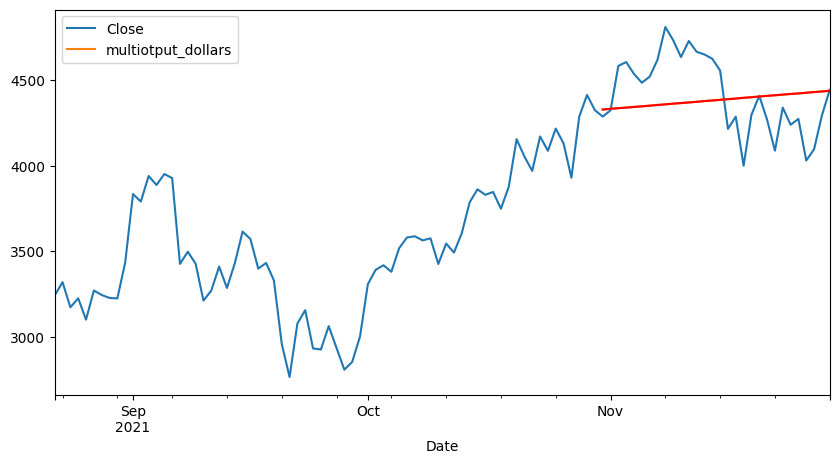

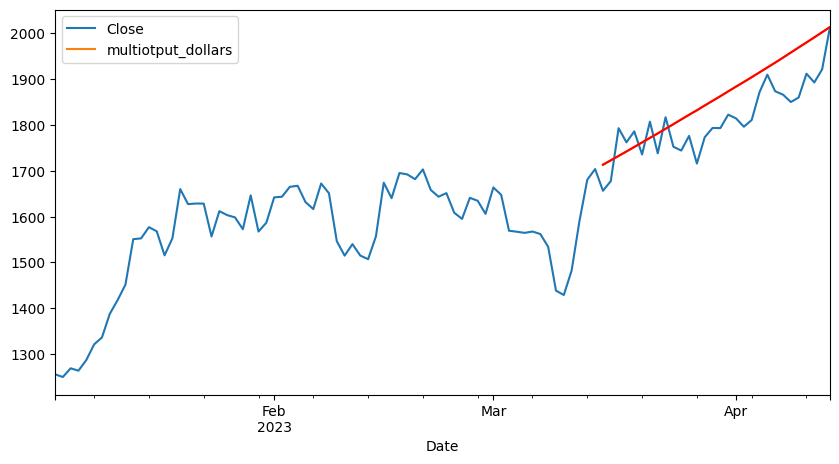

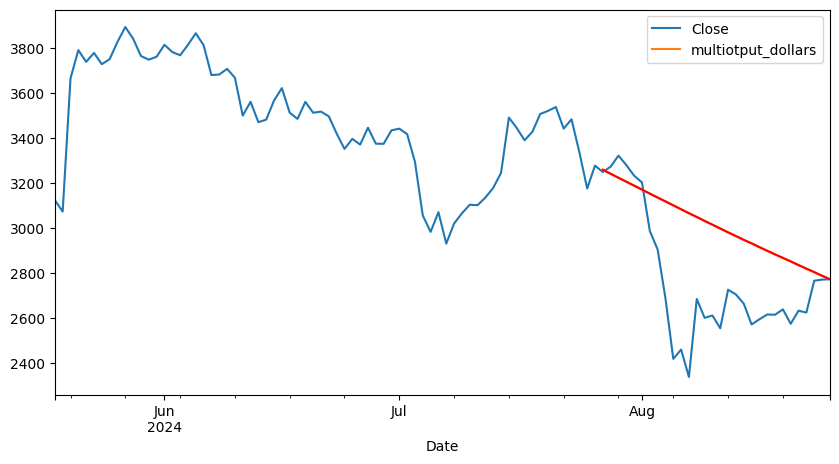

In [5]:
i = 328
real_50d = []
pred_50d = []
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 30
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    Tx = 50
    Ty = Ntest
    X = []
    Y = []
    for t in range(len(series) - Tx - Ty + 1):
      x = series[t:t+Tx]
      X.append(x)
      y = series[t+Tx:t+Tx+Ty]
      Y.append(y)
    
    X = np.array(X).reshape(-1, Tx,1)
    Y = np.array(Y).reshape(-1, Ty)
    
    Xtrain_m, Ytrain_m = X[:-Ntest], Y[:-Ntest]
    Xtest_m, Ytest_m = X[-Ntest:], Y[-Ntest:]
    
    model = KerasRegressor(model=build_lstm_model, verbose=2)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain_m, Ytrain_m,validation_data=(Xtest_m, Ytest_m))
    best_model = grid_result.best_estimator_
    
    Ptest = best_model.predict(Xtest_m)
    
    Ptest = Ptest[0]
    
    Ptest = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()
    
    last_train = train.iloc[-1]['LogClose']
    
    temp.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'multioutput']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.loc[test_idx, 'multiotput_dollars'] = predicted_temp
    
    temp.iloc[-100:][['Close', 'multiotput_dollars']].plot(figsize=(10, 5))
    plt.plot(temp.loc[test_idx, 'multiotput_dollars'],color='red')
    plt.legend()
    
    pred_50d.append(predicted_temp)
    real_50d.append(real_temp)
    print(pred_50d)
    print('############')
    print(real_50d)

Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/100
6/6 - 7s - 1s/step - loss: 1340.3103 - val_loss: 208.3422
Epoch 2/100
6/6 - 1s - 94ms/step - loss: 923.5778 - val_loss: 186.2854
Epoch 3/100
6/6 - 1s - 91ms/step - loss: 838.1061 - val_loss: 178.4861
Epoch 4/100
6/6 - 1s - 89ms/step - loss: 787.5739 - val_loss: 163.4311
Epoch 5/100
6/6 - 1s - 94ms/step - loss: 846.9237 - val_loss: 152.4284
Epoch 6/100
6/6 - 1s - 94ms/step - loss: 637.5916 - val_loss: 144.4742
Epoch 7/100
6/6 - 1s - 89ms/step - loss: 611.1227 - val_loss: 141.8019
Epoch 8/100
6/6 - 1s - 94ms/step - loss: 587.8521 - val_loss: 133.2127
Epoch 9/100
6/6 - 1s - 88ms/step - loss: 609.4235 - val_loss: 121.5211
Epoch 10/100
6/6 - 1s - 94ms/step - loss: 437.7215 - val_loss: 118.5962
Epoch 11/100
6/6 - 1s - 86ms/step - loss: 512.4763 - val_loss: 115.1027
Epoch 12/100
6/6 - 1s - 94ms/step - loss: 418.0841 - val_loss: 115.0441
Epoch 13/100
6/6 - 1s - 94ms/step - loss: 422.0177 - val_loss: 115.8508
Epoch 14/100

C:\Users\Korisnik\Desktop\Diplomski\Eth_price_prediciton\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\Korisnik\Desktop\Diplomski\Eth_price_prediciton\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [-1.97208313e-03 -1.96398173e-03 -1.97832840e-03 -1.92913208e-03
 -1.84601562e-03 -1.92263005e-03 -1.96863347e-03 -2.13625746e-03
 -1.90349767e-03 -1.94092278e-03 -1.88453686e-03 -1.95878285e-03
 -1.86513041e-03 -1.87796647e-03 -1.94185641e-03 -1.93140556e-03
 -1.88930038e-03 -1.90566667e-03 -1.97547017e-03 -1.88275150e-03
 -1.93669647e-03 -1.97406071e-03 -1.95738625e-03 -1.95043885e-03
 -1.93611032e-03 -1.99157293e-03 -1.97379219e-03 -1.92001281e-03
 -1.94394864e-03 -1.88764927e-03 -1.89383068e-03 -1.90911984e-03
 -1.84370

Epoch 1/100
53/53 - 5s - 93ms/step - loss: 102.1872 - val_loss: 100.5113
Epoch 2/100
53/53 - 2s - 35ms/step - loss: 100.8725 - val_loss: 100.3397
Epoch 3/100
53/53 - 2s - 35ms/step - loss: 100.6448 - val_loss: 100.1862
Epoch 4/100
53/53 - 2s - 34ms/step - loss: 100.6639 - val_loss: 100.2084
Epoch 5/100
53/53 - 2s - 35ms/step - loss: 100.6024 - val_loss: 100.1726
Epoch 6/100
53/53 - 2s - 35ms/step - loss: 100.5161 - val_loss: 100.1607
Epoch 7/100
53/53 - 2s - 35ms/step - loss: 100.5142 - val_loss: 100.1461
Epoch 8/100
53/53 - 2s - 35ms/step - loss: 100.4979 - val_loss: 100.1135
Epoch 9/100
53/53 - 2s - 35ms/step - loss: 100.4751 - val_loss: 100.1767
Epoch 10/100
53/53 - 2s - 35ms/step - loss: 100.4767 - val_loss: 100.0874
Epoch 11/100
53/53 - 2s - 35ms/step - loss: 100.5252 - val_loss: 100.1757
Epoch 12/100
53/53 - 2s - 35ms/step - loss: 100.4417 - val_loss: 100.0841
Epoch 13/100
53/53 - 2s - 35ms/step - loss: 100.5185 - val_loss: 100.1018
Epoch 14/100
53/53 - 2s - 37ms/step - loss: 100

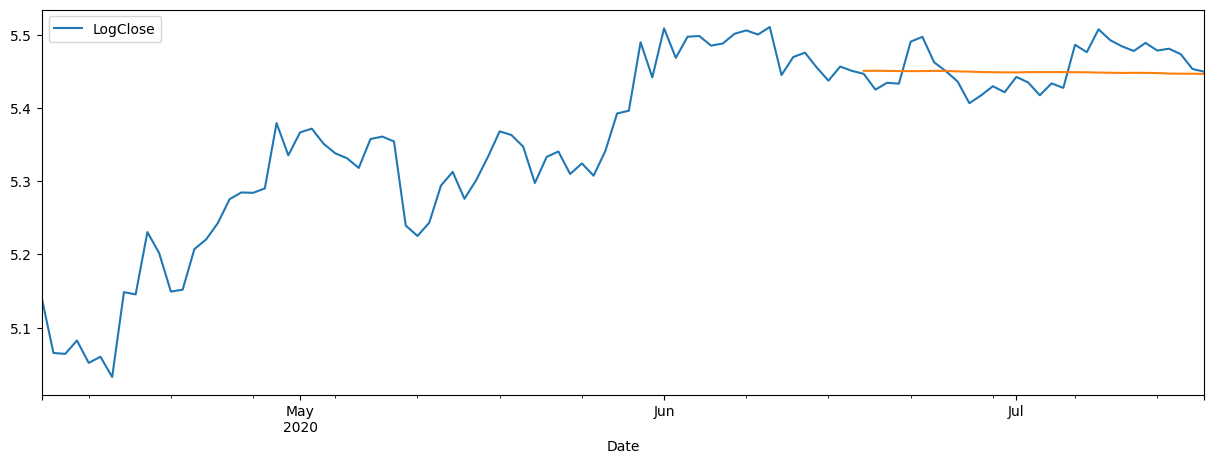

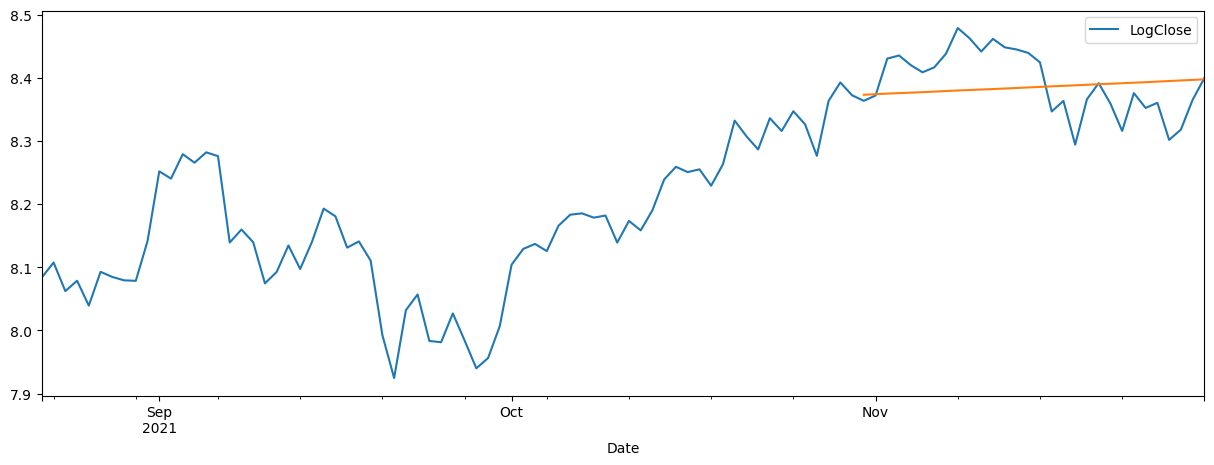

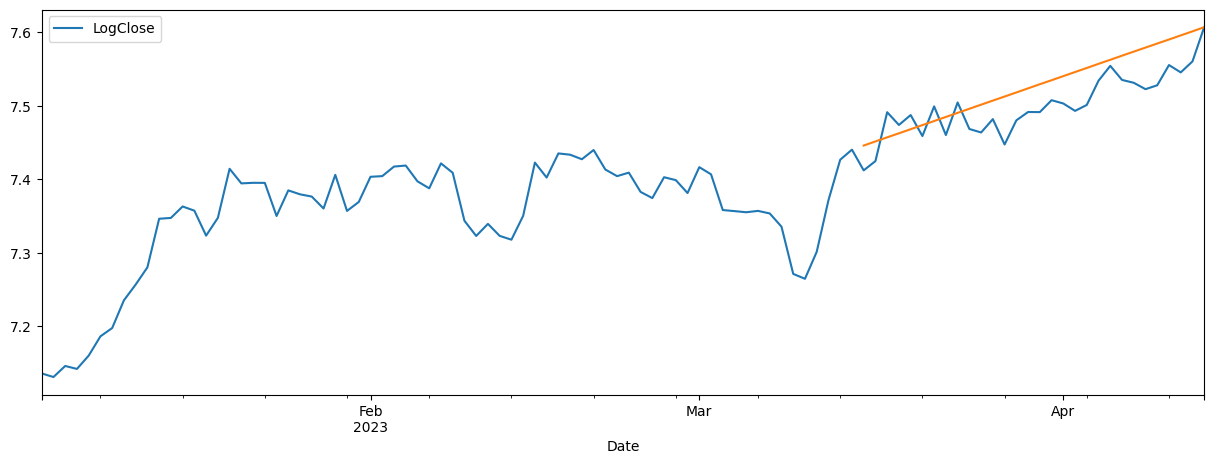

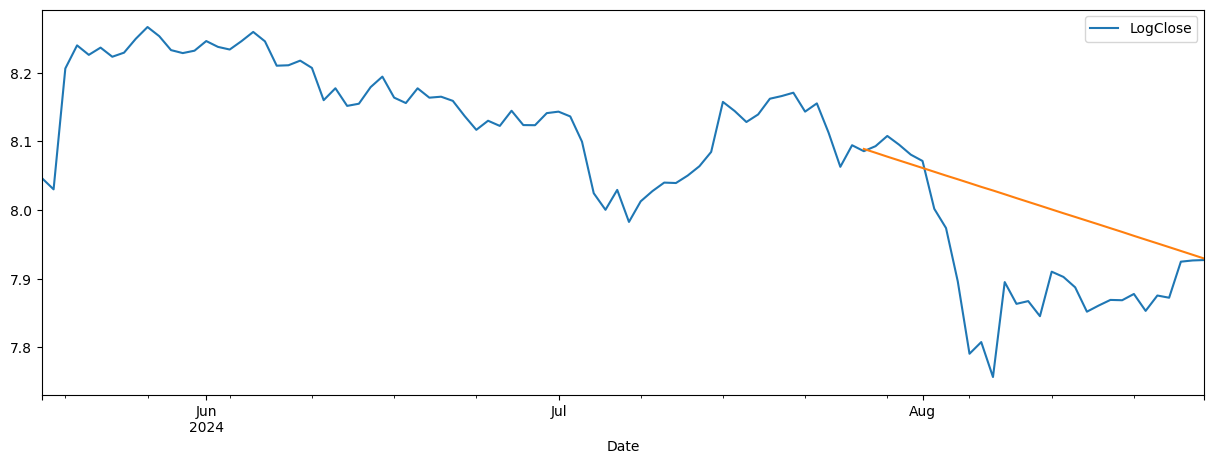

In [23]:
i = 328
real_100d = []
pred_100d = []
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 30
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    Tx = 100
    Ty = Ntest
    X = []
    Y = []
    for t in range(len(series) - Tx - Ty + 1):
      x = series[t:t+Tx]
      X.append(x)
      y = series[t+Tx:t+Tx+Ty]
      Y.append(y)
    
    X = np.array(X).reshape(-1, Tx,1)
    Y = np.array(Y).reshape(-1, Ty)
    
    Xtrain_m, Ytrain_m = X[:-Ntest], Y[:-Ntest]
    Xtest_m, Ytest_m = X[-Ntest:], Y[-Ntest:]
    
    model = KerasRegressor(model=build_lstm_model, verbose=2)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain_m, Ytrain_m,validation_data=(Xtest_m, Ytest_m))
    best_model = grid_result.best_estimator_
    
    Ptest = best_model.predict(Xtest_m)
    
    Ptest = Ptest[0]
    
    Ptest = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()
    
    last_train = train.iloc[-1]['LogClose']
    
    temp.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'multioutput']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.iloc[-100:][['LogClose']].plot(figsize=(15, 5));
    plt.plot(temp.loc[test_idx, 'multioutput'])
    
    pred_100d.append(predicted_temp)
    real_100d.append(real_temp)
    print(pred_100d)
    print('############')
    print(real_100d)

In [7]:
predicted_10d = pred_10d
real_10d = real_10d

In [17]:
predicted_50d = pred_50d
real_50d = real_50d

In [25]:
predicted_100d = pred_100d
real_100d = real_100d

In [26]:
print("R2 score for 10, 50 and 100 days are:",round(r2_score(real_10d, predicted_10d),4), round(r2_score(real_50d, predicted_50d),4),round(r2_score(real_100d, predicted_100d),4))

R2 score for 10, 50 and 100 days are: 0.9823 0.9824 0.9821


In [27]:
print("MAPE score for 10, 50 and 100 days are:",round(mean_absolute_percentage_error(real_10d, predicted_10d)*100,2),round(mean_absolute_percentage_error(real_50d, predicted_50d)*100,2),round(mean_absolute_percentage_error(real_100d, predicted_100d)*100,2))

MAPE score for 10, 50 and 100 days are: 5.13 5.12 5.17


In [28]:
print("MAE scores for 10, 50 and 100 days are:",round(mean_absolute_error(real_10d, predicted_10d),2),round(mean_absolute_error(real_50d, predicted_50d),2),round(mean_absolute_error(real_100d, predicted_100d),2))

MAE scores for 10, 50 and 100 days are: 133.77 133.45 134.35


In [29]:
print("MSE scores for 10, 50 and 100 days are:",round(mean_squared_error(real_10d, predicted_10d),2),round(mean_squared_error(real_50d, predicted_50d),2),round(mean_squared_error(real_100d, predicted_100d),2))

MSE scores for 10, 50 and 100 days are: 42110.72 41980.91 42435.92


In [30]:
print("RMSE scores for 10, 50 and 100 days are:",round(root_mean_squared_error(real_10d, predicted_10d),2),round(root_mean_squared_error(real_50d, predicted_50d),2),round(root_mean_squared_error(real_100d, predicted_100d),2))

RMSE scores for 10, 50 and 100 days are: 181.0 180.64 181.81
